#### Lunar Starship Analysis example

This example shows the basic CITROS data analysis functions and based on the simulations made with MPOPT python library.



First of all, we should import all neccesary libs:

In [36]:
import numpy as np

import matplotlib.pyplot as plt

from citros_data_analysis import data_access as da

from prettytable import PrettyTable, ALL

import json

from platform import python_version



Now we can connect to the simulation database:

In [37]:
batch_id = '0ab406ae-b26c-4404-83c6-fe5ab6804fe3'

citros = da.CitrosDB(batch = batch_id)

citros.info().print()


{
 'size': '125 kB',
 'sid_count': 10,
 'sid_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'topic_count': 2,
 'topic_list': ['/config', '/lunar_starship/state'],
 'message_count': 372
}


As you can see in the output above, we've got some information about our simulation run (batch):
1. Size of data
2. Sid information. In case we have more then one sid - this will be shown here.
3. Number and a list of topics. First three topics are build-in system topics, and the last one is our simulation results. 

Let's go further:

In [38]:
citros.sid([0]).info().print()

{
 'size': '32 kB',
 'sid_count': 1,
 'sid_list': [0],
 'topic_count': 2,
 'topic_list': ['/config', '/lunar_starship/state'],
 'message_count': 98,
 'sids': {
   0: {
     'topics': {
       '/config': {
         'message_count': 1,
         'start_time': 0,
         'end_time': 0,
         'duration': 0,
         'frequency': 0
       },
       '/lunar_starship/state': {
         'message_count': 97,
         'start_time': 1696239807847951229,
         'end_time': 1696239903847115759,
         'duration': 95999164530,
         'frequency': 1.01
       }
     }
   }
 }
}


This shows us more detailed statistics about topics: time stamps, durations, number of messages etc.
Let's inspect our data topic:

In [39]:
citros.topic('/lunar_starship/state').sid(0).info().print()

{
 'size': '32 kB',
 'sid_count': 1,
 'sid_list': [0],
 'topic_count': 1,
 'topic_list': ['/lunar_starship/state'],
 'message_count': 97,
 'sids': {
   0: {
     'topics': {
       '/lunar_starship/state': {
         'message_count': 97,
         'start_time': 1696239807847951229,
         'end_time': 1696239903847115759,
         'duration': 95999164530,
         'frequency': 1.01
       }
     }
   }
 },
 'topics': {
   '/lunar_starship/state': {
     'type': 'std_msgs/msg/Float64MultiArray',
     'data_structure': {
       'data': {
         'data': 'list',
         '__msgtype__': 'str'
       }
     },
     'message_count': 97
   }
 }
}


Here we can see that our data topic contains 99 messages, and each one's type is a Float64MultiArray. 
Let's print all raw data:

In [40]:
print(citros.topic('/lunar_starship/state').data())

     sid  rid                 time                  topic  \
0      0    0  1696239807847951229  /lunar_starship/state   
1      0    1  1696239808847122953  /lunar_starship/state   
2      0    2  1696239809847213693  /lunar_starship/state   
3      0    3  1696239810847224135  /lunar_starship/state   
4      0    4  1696239811847222585  /lunar_starship/state   
..   ...  ...                  ...                    ...   
357    9   33  1696239146168623298  /lunar_starship/state   
358    9   34  1696239147168775092  /lunar_starship/state   
359    9   35  1696239148168655651  /lunar_starship/state   
360    9   36  1696239149168653195  /lunar_starship/state   
361    9   37  1696239150168787073  /lunar_starship/state   

                               type  \
0    std_msgs/msg/Float64MultiArray   
1    std_msgs/msg/Float64MultiArray   
2    std_msgs/msg/Float64MultiArray   
3    std_msgs/msg/Float64MultiArray   
4    std_msgs/msg/Float64MultiArray   
..                              .

To get all json-data columns for a specific topic, function data() is used. It returns pandas DataFrame. To get a specific columns, pass their labels in a list as an argument:

In [41]:
print(citros.topic('/lunar_starship/state').data(['data.data[0]','data.data[1]'])[['data.data[0]', 'data.data[1]']])

     data.data[0]  data.data[1]
0    6.386575e-08      1.570787
1    3.788473e-01      1.570786
2    3.136908e+00      1.570784
3    6.952824e+00      1.570781
4    7.234659e+00      1.570777
..            ...           ...
357  7.097655e+02      1.570687
358  7.585401e+02      1.570674
359  8.099018e+02      1.570661
360  8.648599e+02      1.570648
361  9.241880e+02      1.570634

[362 rows x 2 columns]


Now we can create some plots. Let's plot coordinates along one of the axes (supposing messages come once a second): 

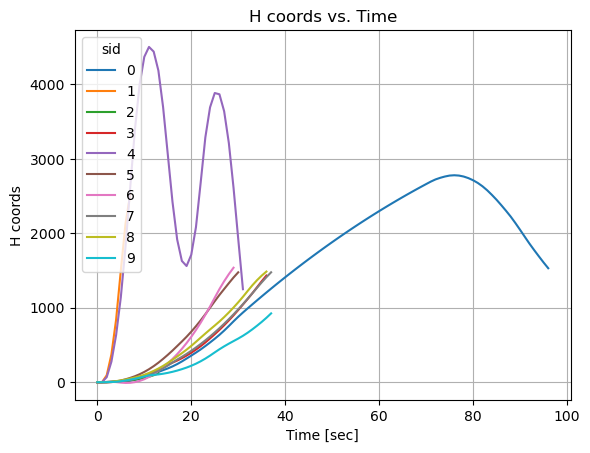

In [63]:
fig1, ax1 = plt.subplots()



citros.time_plot(ax1, 

                 topic_name = '/lunar_starship/state', 

                 var_name = 'data.data[0]', 

                 time_step = 1, 

                 sids = [0,1,2,3,4,5,6,7,8,9], 

                 y_label = 'H coords', title_text = 'H coords vs. Time')

You can see here more than one sids - the simulation batch settings have been adjusted in such a way that each simulation corresponds to a parameter value from the range [200..300].

Let's do some simple research. This simulation was started with custom parameter setup: one of the parameters (`Isp`) was defined with user-defined function, so we will see some difference between sid's data. We will use this CITROS advantage to analyze how Specific impulse affects on the Starship flight:

Text(0.5, 1.0, 'Travelled distance vs Specific impulse')

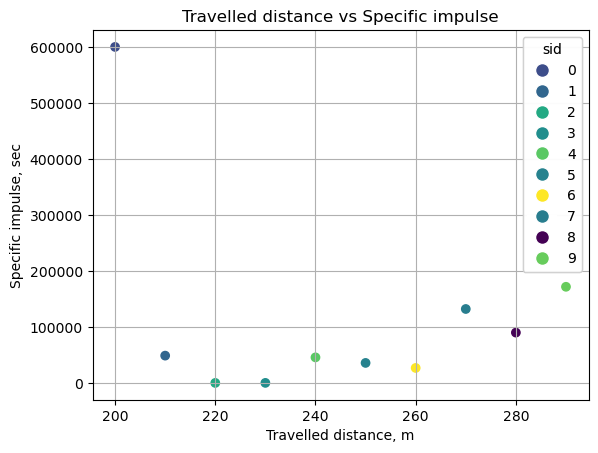

In [ ]:
import math

# Setting Dataframe and getting initial and final coords
df = citros.topic('/lunar_starship/state').set_order({'sid':'asc'}).data('data.data[1]')
dff = citros.topic('/lunar_starship/state').set_order({'sid':'asc'}).data('data.data[2]')
sid_list = list(set(df['sid']))
lat0_list = []
latf_list = []
long0_list = []
longf_list = []
for s in sid_list:
    id_max = df[df['sid'] == s]['rid'].idxmax()
    id_min = df[df['sid'] == s]['rid'].idxmin()
    lat0_list.append(df['data.data[1]'].loc[id_min])
    latf_list.append(df['data.data[1]'].loc[id_max])
    long0_list.append(dff['data.data[2]'].loc[id_min])
    longf_list.append(dff['data.data[2]'].loc[id_max])

# Moon radius
rad = 1737400

# Calculating travelled distance for each sid
dist_list= []
for i in range(len(sid_list)):

    llat1 = lat0_list[i]
    llong1 = long0_list[i]

    llat2 = latf_list[i]
    llong2 = longf_list[i]

    lat1 = llat1*math.pi/180.
    lat2 = llat2*math.pi/180.
    long1 = llong1*math.pi/180.
    long2 = llong2*math.pi/180.

    cl1 = math.cos(lat1)
    cl2 = math.cos(lat2)
    sl1 = math.sin(lat1)
    sl2 = math.sin(lat2)
    delta = long2 - long1
    cdelta = math.cos(delta)
    sdelta = math.sin(delta)

    #вычисления длины большого круга
    y = math.sqrt(math.pow(cl2*sdelta,2)+math.pow(cl1*sl2-sl1*cl2*cdelta,2))
    x = sl1*sl2+cl1*cl2*cdelta
    ad = math.atan2(y,x)
    dist_list.append(ad*rad)


# Defining the list of Isp

isp = [i for i in range(200,300, 10)]


fig, ax = plt.subplots()

c = np.random.choice(50, 10, replace=False)
scatter = ax.scatter(isp, dist_list,c=c)

# Create legend entries for each point
legend_labels = [str(i) for i in range(10)]

# Initialize a list to store legend handles
legend_handles = []

# Loop through the points and create legend entries with matching colors
for i, label in enumerate(legend_labels):
    color = scatter.to_rgba(c[i])  # Get the color of the corresponding point
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))

# Add the legend with custom handles
legend1 = ax.legend(handles=legend_handles, loc="upper right", title="sid")
ax.add_artist(legend1)
ax.grid()

ax.set_xlabel('Specific impulse, sec')
ax.set_ylabel('Travelled distance, m')
ax.set_title('Travelled distance vs Specific impulse')
# plt.legend()